# Coding Exercise: Domain Adaption Meta Learning

For this tutorial, we will be showcasing use of Domain Adaption Meta Learning, to learn a simple curve of sinusoidal data. It's a variation of 'Model Agnostic Meta Learning', but with added prior information i.e; extra relevant information about domain is already added.

Let's Begin!!!!

#### Step 1: Import all libraries 

In [1]:
import math
import random
import torch # v0.4.1
from torch import nn
from torch.nn import functional as F
import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline

#### Step 2: Create a simple neural network architecture, which is going to learn the sinusoidal curve.
As mentioned above, we will be getting randomly generated data of sinusoidal curve so, we will be using this very small network, as we don't need a big one to learn a curve.

In [2]:
def net(x, params):
    x = F.linear(x, params[0], params[1])
    x1 = F.relu(x)

    x = F.linear(x1, params[2], params[3])
    x2 = F.relu(x)

    y = F.linear(x2, params[4], params[5])

    return y, x2, x1

params = [
    torch.Tensor(32, 1).uniform_(-1., 1.).requires_grad_(),
    torch.Tensor(32).zero_().requires_grad_(),

    torch.Tensor(32, 32).uniform_(-1./math.sqrt(32), 1./math.sqrt(32)).requires_grad_(),
    torch.Tensor(32).zero_().requires_grad_(),

    torch.Tensor(1, 32).uniform_(-1./math.sqrt(32), 1./math.sqrt(32)).requires_grad_(),
    torch.Tensor(1).zero_().requires_grad_(),
]

##### Step 3: Create another simple neural network architecture, for adding prior information about domain.
As mentioned above, we will be adding a prior knowledge to our main net. Therefore, we need to create a simple adap_net.

In [3]:
def adap_net(y, x2, x1, params):
    x = torch.cat([y, x2, x1], dim=1)

    x = F.linear(x, params[0], params[1])
    x = F.relu(x)

    x = F.linear(x, params[2], params[3])
    x = F.relu(x)

    x = F.linear(x, params[4], params[5])

    return x

adap_params = [
    torch.Tensor(32, 1+32+32).uniform_(-1./math.sqrt(65), 1./math.sqrt(65)).requires_grad_(),
    torch.Tensor(32).zero_().requires_grad_(),

    torch.Tensor(32, 32).uniform_(-1./math.sqrt(32), 1./math.sqrt(32)).requires_grad_(),
    torch.Tensor(32).zero_().requires_grad_(),

    torch.Tensor(1, 32).uniform_(-1./math.sqrt(32), 1./math.sqrt(32)).requires_grad_(),
    torch.Tensor(1).zero_().requires_grad_(),
]

#### step 4: set up parameters for training
so as we are going to use inner loop vs outer loop training as mentioned in DAML paper. thus, we need to set certain parameters such as alpha, beta, learning rate, optimizer, and number of loops. 

In [4]:
opt = torch.optim.SGD(params + adap_params, lr=1e-2)
n_inner_loop = 5
alpha = 3e-2

#### Step 5: Implement Optimization Algorithm 

In [5]:
inner_loop_loss=[]
outer_lopp_loss=[]

for it in range(100000):
    b = 0 if random.choice([True, False]) else math.pi
    
    #### Randomly obtain the task 2 sinusoidal data ####
    v_x = torch.rand(4, 1)*4*math.pi - 2*math.pi
    v_y = torch.sin(v_x + b)

    opt.zero_grad()

    new_params = params
    for k in range(n_inner_loop):
        f, f2, f1 = net(torch.FloatTensor([[random.uniform(math.pi/4, math.pi/2) if b == 0 else random.uniform(-math.pi/2, -math.pi/4)]]), new_params)
        h = adap_net(f, f2, f1, adap_params)
        adap_loss = F.l1_loss(h, torch.zeros(1, 1))

        # create_graph=True because computing grads here is part of the forward pass.
        # We want to differentiate through the SGD update steps and get higher order
        # derivatives in the backward pass.
        grads = torch.autograd.grad(adap_loss, new_params, create_graph=True)
        new_params = [(new_params[i] - alpha*grads[i]) for i in range(len(params))]

        if it % 100 == 0: 
            inner_loop_loss.append(adap_loss)

    v_f, _, _ = net(v_x, new_params)
    loss = F.l1_loss(v_f, v_y)
    loss.backward()

    opt.step()

    if it % 100 == 0: 
        outer_lopp_loss.append(loss)
        print ('Iteration: %d Loss: %.4f' % (it, loss))


Iteration 0 -- Inner loop 0 -- Loss: 0.0456
Iteration 0 -- Inner loop 1 -- Loss: 0.0385
Iteration 0 -- Inner loop 2 -- Loss: 0.0481
Iteration 0 -- Inner loop 3 -- Loss: 0.0312
Iteration 0 -- Inner loop 4 -- Loss: 0.0430
Iteration 0 -- Outer Loss: 0.6839
Iteration 100 -- Inner loop 0 -- Loss: 0.0547
Iteration 100 -- Inner loop 1 -- Loss: 0.0392
Iteration 100 -- Inner loop 2 -- Loss: 0.0492
Iteration 100 -- Inner loop 3 -- Loss: 0.0346
Iteration 100 -- Inner loop 4 -- Loss: 0.0312
Iteration 100 -- Outer Loss: 0.7017
Iteration 200 -- Inner loop 0 -- Loss: 0.1110
Iteration 200 -- Inner loop 1 -- Loss: 0.0917
Iteration 200 -- Inner loop 2 -- Loss: 0.0882
Iteration 200 -- Inner loop 3 -- Loss: 0.1016
Iteration 200 -- Inner loop 4 -- Loss: 0.0797
Iteration 200 -- Outer Loss: 0.7695
Iteration 300 -- Inner loop 0 -- Loss: 0.0706
Iteration 300 -- Inner loop 1 -- Loss: 0.0380
Iteration 300 -- Inner loop 2 -- Loss: 0.0488
Iteration 300 -- Inner loop 3 -- Loss: 0.0626
Iteration 300 -- Inner loop 4 

Iteration 3100 -- Inner loop 0 -- Loss: 0.4505
Iteration 3100 -- Inner loop 1 -- Loss: 0.2690
Iteration 3100 -- Inner loop 2 -- Loss: 0.3371
Iteration 3100 -- Inner loop 3 -- Loss: 0.2680
Iteration 3100 -- Inner loop 4 -- Loss: 0.1584
Iteration 3100 -- Outer Loss: 0.9489
Iteration 3200 -- Inner loop 0 -- Loss: 0.9543
Iteration 3200 -- Inner loop 1 -- Loss: 0.7764
Iteration 3200 -- Inner loop 2 -- Loss: 0.3486
Iteration 3200 -- Inner loop 3 -- Loss: 0.2852
Iteration 3200 -- Inner loop 4 -- Loss: 0.4034
Iteration 3200 -- Outer Loss: 0.5853
Iteration 3300 -- Inner loop 0 -- Loss: 0.5185
Iteration 3300 -- Inner loop 1 -- Loss: 0.9106
Iteration 3300 -- Inner loop 2 -- Loss: 0.5488
Iteration 3300 -- Inner loop 3 -- Loss: 0.6529
Iteration 3300 -- Inner loop 4 -- Loss: 0.6207
Iteration 3300 -- Outer Loss: 0.9658
Iteration 3400 -- Inner loop 0 -- Loss: 0.4089
Iteration 3400 -- Inner loop 1 -- Loss: 0.2040
Iteration 3400 -- Inner loop 2 -- Loss: 0.0942
Iteration 3400 -- Inner loop 3 -- Loss: 0.0

Iteration 6200 -- Inner loop 0 -- Loss: 1.3672
Iteration 6200 -- Inner loop 1 -- Loss: 1.0271
Iteration 6200 -- Inner loop 2 -- Loss: 1.0327
Iteration 6200 -- Inner loop 3 -- Loss: 0.6830
Iteration 6200 -- Inner loop 4 -- Loss: 0.6994
Iteration 6200 -- Outer Loss: 0.7813
Iteration 6300 -- Inner loop 0 -- Loss: 1.6467
Iteration 6300 -- Inner loop 1 -- Loss: 1.5339
Iteration 6300 -- Inner loop 2 -- Loss: 1.0749
Iteration 6300 -- Inner loop 3 -- Loss: 0.4837
Iteration 6300 -- Inner loop 4 -- Loss: 0.3345
Iteration 6300 -- Outer Loss: 0.4803
Iteration 6400 -- Inner loop 0 -- Loss: 1.1404
Iteration 6400 -- Inner loop 1 -- Loss: 1.3328
Iteration 6400 -- Inner loop 2 -- Loss: 0.7703
Iteration 6400 -- Inner loop 3 -- Loss: 1.2205
Iteration 6400 -- Inner loop 4 -- Loss: 0.7869
Iteration 6400 -- Outer Loss: 0.7197
Iteration 6500 -- Inner loop 0 -- Loss: 0.7646
Iteration 6500 -- Inner loop 1 -- Loss: 0.5555
Iteration 6500 -- Inner loop 2 -- Loss: 0.3538
Iteration 6500 -- Inner loop 3 -- Loss: 0.4

Iteration 9300 -- Inner loop 0 -- Loss: 1.2877
Iteration 9300 -- Inner loop 1 -- Loss: 0.9416
Iteration 9300 -- Inner loop 2 -- Loss: 0.6963
Iteration 9300 -- Inner loop 3 -- Loss: 0.9830
Iteration 9300 -- Inner loop 4 -- Loss: 0.8558
Iteration 9300 -- Outer Loss: 0.3166
Iteration 9400 -- Inner loop 0 -- Loss: 2.7127
Iteration 9400 -- Inner loop 1 -- Loss: 1.7671
Iteration 9400 -- Inner loop 2 -- Loss: 1.5076
Iteration 9400 -- Inner loop 3 -- Loss: 1.1937
Iteration 9400 -- Inner loop 4 -- Loss: 0.3281
Iteration 9400 -- Outer Loss: 0.3739
Iteration 9500 -- Inner loop 0 -- Loss: 1.1702
Iteration 9500 -- Inner loop 1 -- Loss: 1.3889
Iteration 9500 -- Inner loop 2 -- Loss: 0.8517
Iteration 9500 -- Inner loop 3 -- Loss: 0.8098
Iteration 9500 -- Inner loop 4 -- Loss: 0.5830
Iteration 9500 -- Outer Loss: 0.8179
Iteration 9600 -- Inner loop 0 -- Loss: 0.9856
Iteration 9600 -- Inner loop 1 -- Loss: 0.9439
Iteration 9600 -- Inner loop 2 -- Loss: 1.1872
Iteration 9600 -- Inner loop 3 -- Loss: 0.6

Iteration 12300 -- Inner loop 0 -- Loss: 2.7225
Iteration 12300 -- Inner loop 1 -- Loss: 1.1835
Iteration 12300 -- Inner loop 2 -- Loss: 1.3858
Iteration 12300 -- Inner loop 3 -- Loss: 0.1054
Iteration 12300 -- Inner loop 4 -- Loss: 0.3789
Iteration 12300 -- Outer Loss: 0.3235
Iteration 12400 -- Inner loop 0 -- Loss: 2.9807
Iteration 12400 -- Inner loop 1 -- Loss: 2.1001
Iteration 12400 -- Inner loop 2 -- Loss: 1.8818
Iteration 12400 -- Inner loop 3 -- Loss: 1.2170
Iteration 12400 -- Inner loop 4 -- Loss: 0.6546
Iteration 12400 -- Outer Loss: 0.6558
Iteration 12500 -- Inner loop 0 -- Loss: 1.9656
Iteration 12500 -- Inner loop 1 -- Loss: 1.0504
Iteration 12500 -- Inner loop 2 -- Loss: 1.9187
Iteration 12500 -- Inner loop 3 -- Loss: 0.7767
Iteration 12500 -- Inner loop 4 -- Loss: 0.6644
Iteration 12500 -- Outer Loss: 0.4144
Iteration 12600 -- Inner loop 0 -- Loss: 2.1679
Iteration 12600 -- Inner loop 1 -- Loss: 1.6818
Iteration 12600 -- Inner loop 2 -- Loss: 1.0205
Iteration 12600 -- Inn

Iteration 15300 -- Inner loop 0 -- Loss: 1.9606
Iteration 15300 -- Inner loop 1 -- Loss: 2.2917
Iteration 15300 -- Inner loop 2 -- Loss: 1.6159
Iteration 15300 -- Inner loop 3 -- Loss: 1.4721
Iteration 15300 -- Inner loop 4 -- Loss: 1.0742
Iteration 15300 -- Outer Loss: 0.6785
Iteration 15400 -- Inner loop 0 -- Loss: 7.6743
Iteration 15400 -- Inner loop 1 -- Loss: 1.0518
Iteration 15400 -- Inner loop 2 -- Loss: 0.0434
Iteration 15400 -- Inner loop 3 -- Loss: 0.0542
Iteration 15400 -- Inner loop 4 -- Loss: 0.0307
Iteration 15400 -- Outer Loss: 0.2888
Iteration 15500 -- Inner loop 0 -- Loss: 2.5776
Iteration 15500 -- Inner loop 1 -- Loss: 2.1183
Iteration 15500 -- Inner loop 2 -- Loss: 2.8792
Iteration 15500 -- Inner loop 3 -- Loss: 1.0710
Iteration 15500 -- Inner loop 4 -- Loss: 0.9590
Iteration 15500 -- Outer Loss: 0.2271
Iteration 15600 -- Inner loop 0 -- Loss: 3.4675
Iteration 15600 -- Inner loop 1 -- Loss: 2.3965
Iteration 15600 -- Inner loop 2 -- Loss: 1.9674
Iteration 15600 -- Inn

Iteration 18300 -- Inner loop 0 -- Loss: 11.5531
Iteration 18300 -- Inner loop 1 -- Loss: 0.0220
Iteration 18300 -- Inner loop 2 -- Loss: 0.0195
Iteration 18300 -- Inner loop 3 -- Loss: 0.0190
Iteration 18300 -- Inner loop 4 -- Loss: 0.0194
Iteration 18300 -- Outer Loss: 0.3659
Iteration 18400 -- Inner loop 0 -- Loss: 12.3300
Iteration 18400 -- Inner loop 1 -- Loss: 0.0246
Iteration 18400 -- Inner loop 2 -- Loss: 0.0231
Iteration 18400 -- Inner loop 3 -- Loss: 0.0165
Iteration 18400 -- Inner loop 4 -- Loss: 0.0235
Iteration 18400 -- Outer Loss: 0.3636
Iteration 18500 -- Inner loop 0 -- Loss: 10.8377
Iteration 18500 -- Inner loop 1 -- Loss: 0.0244
Iteration 18500 -- Inner loop 2 -- Loss: 0.0237
Iteration 18500 -- Inner loop 3 -- Loss: 0.0224
Iteration 18500 -- Inner loop 4 -- Loss: 0.0218
Iteration 18500 -- Outer Loss: 0.0645
Iteration 18600 -- Inner loop 0 -- Loss: 8.3295
Iteration 18600 -- Inner loop 1 -- Loss: 0.0128
Iteration 18600 -- Inner loop 2 -- Loss: 0.0147
Iteration 18600 -- 

Iteration 21300 -- Inner loop 0 -- Loss: 9.1894
Iteration 21300 -- Inner loop 1 -- Loss: 0.0337
Iteration 21300 -- Inner loop 2 -- Loss: 0.0147
Iteration 21300 -- Inner loop 3 -- Loss: 0.0125
Iteration 21300 -- Inner loop 4 -- Loss: 0.0308
Iteration 21300 -- Outer Loss: 0.2871
Iteration 21400 -- Inner loop 0 -- Loss: 7.3372
Iteration 21400 -- Inner loop 1 -- Loss: 0.6436
Iteration 21400 -- Inner loop 2 -- Loss: 0.2846
Iteration 21400 -- Inner loop 3 -- Loss: 0.0153
Iteration 21400 -- Inner loop 4 -- Loss: 0.0118
Iteration 21400 -- Outer Loss: 0.3363
Iteration 21500 -- Inner loop 0 -- Loss: 12.3137
Iteration 21500 -- Inner loop 1 -- Loss: 0.2254
Iteration 21500 -- Inner loop 2 -- Loss: 1.1781
Iteration 21500 -- Inner loop 3 -- Loss: 0.1240
Iteration 21500 -- Inner loop 4 -- Loss: 0.0287
Iteration 21500 -- Outer Loss: 0.3609
Iteration 21600 -- Inner loop 0 -- Loss: 11.7274
Iteration 21600 -- Inner loop 1 -- Loss: 0.8225
Iteration 21600 -- Inner loop 2 -- Loss: 0.0156
Iteration 21600 -- I

Iteration 24300 -- Inner loop 0 -- Loss: 10.5373
Iteration 24300 -- Inner loop 1 -- Loss: 0.0283
Iteration 24300 -- Inner loop 2 -- Loss: 0.0298
Iteration 24300 -- Inner loop 3 -- Loss: 0.0182
Iteration 24300 -- Inner loop 4 -- Loss: 0.0287
Iteration 24300 -- Outer Loss: 0.1774
Iteration 24400 -- Inner loop 0 -- Loss: 9.7354
Iteration 24400 -- Inner loop 1 -- Loss: 2.4115
Iteration 24400 -- Inner loop 2 -- Loss: 0.1089
Iteration 24400 -- Inner loop 3 -- Loss: 0.0546
Iteration 24400 -- Inner loop 4 -- Loss: 0.0376
Iteration 24400 -- Outer Loss: 0.2666
Iteration 24500 -- Inner loop 0 -- Loss: 12.6094
Iteration 24500 -- Inner loop 1 -- Loss: 0.0442
Iteration 24500 -- Inner loop 2 -- Loss: 0.0446
Iteration 24500 -- Inner loop 3 -- Loss: 0.0392
Iteration 24500 -- Inner loop 4 -- Loss: 0.0340
Iteration 24500 -- Outer Loss: 0.4073
Iteration 24600 -- Inner loop 0 -- Loss: 12.9593
Iteration 24600 -- Inner loop 1 -- Loss: 0.2224
Iteration 24600 -- Inner loop 2 -- Loss: 0.1129
Iteration 24600 -- 

Iteration 27300 -- Inner loop 0 -- Loss: 11.6653
Iteration 27300 -- Inner loop 1 -- Loss: 0.0589
Iteration 27300 -- Inner loop 2 -- Loss: 0.0567
Iteration 27300 -- Inner loop 3 -- Loss: 0.0396
Iteration 27300 -- Inner loop 4 -- Loss: 0.0313
Iteration 27300 -- Outer Loss: 0.0758
Iteration 27400 -- Inner loop 0 -- Loss: 13.4298
Iteration 27400 -- Inner loop 1 -- Loss: 0.0510
Iteration 27400 -- Inner loop 2 -- Loss: 0.0443
Iteration 27400 -- Inner loop 3 -- Loss: 0.0328
Iteration 27400 -- Inner loop 4 -- Loss: 0.0450
Iteration 27400 -- Outer Loss: 0.1539
Iteration 27500 -- Inner loop 0 -- Loss: 12.2618
Iteration 27500 -- Inner loop 1 -- Loss: 0.0288
Iteration 27500 -- Inner loop 2 -- Loss: 0.0325
Iteration 27500 -- Inner loop 3 -- Loss: 0.0408
Iteration 27500 -- Inner loop 4 -- Loss: 0.0310
Iteration 27500 -- Outer Loss: 0.0904
Iteration 27600 -- Inner loop 0 -- Loss: 13.8128
Iteration 27600 -- Inner loop 1 -- Loss: 0.0506
Iteration 27600 -- Inner loop 2 -- Loss: 0.0300
Iteration 27600 --

Iteration 30300 -- Inner loop 0 -- Loss: 14.8000
Iteration 30300 -- Inner loop 1 -- Loss: 1.1096
Iteration 30300 -- Inner loop 2 -- Loss: 0.0197
Iteration 30300 -- Inner loop 3 -- Loss: 0.0287
Iteration 30300 -- Inner loop 4 -- Loss: 0.0197
Iteration 30300 -- Outer Loss: 0.1069
Iteration 30400 -- Inner loop 0 -- Loss: 14.7233
Iteration 30400 -- Inner loop 1 -- Loss: 0.0836
Iteration 30400 -- Inner loop 2 -- Loss: 0.0794
Iteration 30400 -- Inner loop 3 -- Loss: 0.0904
Iteration 30400 -- Inner loop 4 -- Loss: 0.0877
Iteration 30400 -- Outer Loss: 0.0168
Iteration 30500 -- Inner loop 0 -- Loss: 14.4845
Iteration 30500 -- Inner loop 1 -- Loss: 0.0719
Iteration 30500 -- Inner loop 2 -- Loss: 0.0921
Iteration 30500 -- Inner loop 3 -- Loss: 0.0696
Iteration 30500 -- Inner loop 4 -- Loss: 0.0652
Iteration 30500 -- Outer Loss: 0.2592
Iteration 30600 -- Inner loop 0 -- Loss: 12.6305
Iteration 30600 -- Inner loop 1 -- Loss: 1.7825
Iteration 30600 -- Inner loop 2 -- Loss: 0.0303
Iteration 30600 --

Iteration 33300 -- Inner loop 0 -- Loss: 13.7707
Iteration 33300 -- Inner loop 1 -- Loss: 1.7999
Iteration 33300 -- Inner loop 2 -- Loss: 0.0854
Iteration 33300 -- Inner loop 3 -- Loss: 0.2105
Iteration 33300 -- Inner loop 4 -- Loss: 0.0426
Iteration 33300 -- Outer Loss: 0.0289
Iteration 33400 -- Inner loop 0 -- Loss: 11.5555
Iteration 33400 -- Inner loop 1 -- Loss: 3.0203
Iteration 33400 -- Inner loop 2 -- Loss: 0.0789
Iteration 33400 -- Inner loop 3 -- Loss: 0.0647
Iteration 33400 -- Inner loop 4 -- Loss: 0.0537
Iteration 33400 -- Outer Loss: 0.3576
Iteration 33500 -- Inner loop 0 -- Loss: 13.6379
Iteration 33500 -- Inner loop 1 -- Loss: 2.0117
Iteration 33500 -- Inner loop 2 -- Loss: 0.4056
Iteration 33500 -- Inner loop 3 -- Loss: 0.0497
Iteration 33500 -- Inner loop 4 -- Loss: 0.0484
Iteration 33500 -- Outer Loss: 0.1435
Iteration 33600 -- Inner loop 0 -- Loss: 13.2121
Iteration 33600 -- Inner loop 1 -- Loss: 1.9247
Iteration 33600 -- Inner loop 2 -- Loss: 0.2381
Iteration 33600 --

Iteration 36300 -- Inner loop 0 -- Loss: 9.9644
Iteration 36300 -- Inner loop 1 -- Loss: 2.1420
Iteration 36300 -- Inner loop 2 -- Loss: 0.5262
Iteration 36300 -- Inner loop 3 -- Loss: 0.0978
Iteration 36300 -- Inner loop 4 -- Loss: 0.0250
Iteration 36300 -- Outer Loss: 0.0588
Iteration 36400 -- Inner loop 0 -- Loss: 10.1368
Iteration 36400 -- Inner loop 1 -- Loss: 1.9817
Iteration 36400 -- Inner loop 2 -- Loss: 0.6354
Iteration 36400 -- Inner loop 3 -- Loss: 0.0251
Iteration 36400 -- Inner loop 4 -- Loss: 0.0247
Iteration 36400 -- Outer Loss: 0.0432
Iteration 36500 -- Inner loop 0 -- Loss: 10.7679
Iteration 36500 -- Inner loop 1 -- Loss: 4.0741
Iteration 36500 -- Inner loop 2 -- Loss: 1.1933
Iteration 36500 -- Inner loop 3 -- Loss: 0.7450
Iteration 36500 -- Inner loop 4 -- Loss: 0.1487
Iteration 36500 -- Outer Loss: 0.0829
Iteration 36600 -- Inner loop 0 -- Loss: 10.3341
Iteration 36600 -- Inner loop 1 -- Loss: 1.8279
Iteration 36600 -- Inner loop 2 -- Loss: 0.0485
Iteration 36600 -- 

Iteration 39300 -- Inner loop 0 -- Loss: 10.3078
Iteration 39300 -- Inner loop 1 -- Loss: 3.4886
Iteration 39300 -- Inner loop 2 -- Loss: 0.3400
Iteration 39300 -- Inner loop 3 -- Loss: 0.0366
Iteration 39300 -- Inner loop 4 -- Loss: 0.0480
Iteration 39300 -- Outer Loss: 0.1736
Iteration 39400 -- Inner loop 0 -- Loss: 9.1769
Iteration 39400 -- Inner loop 1 -- Loss: 3.3286
Iteration 39400 -- Inner loop 2 -- Loss: 1.4624
Iteration 39400 -- Inner loop 3 -- Loss: 0.7186
Iteration 39400 -- Inner loop 4 -- Loss: 0.2885
Iteration 39400 -- Outer Loss: 0.1239
Iteration 39500 -- Inner loop 0 -- Loss: 8.6695
Iteration 39500 -- Inner loop 1 -- Loss: 3.3931
Iteration 39500 -- Inner loop 2 -- Loss: 1.5866
Iteration 39500 -- Inner loop 3 -- Loss: 0.2774
Iteration 39500 -- Inner loop 4 -- Loss: 0.0354
Iteration 39500 -- Outer Loss: 0.0250
Iteration 39600 -- Inner loop 0 -- Loss: 8.3050
Iteration 39600 -- Inner loop 1 -- Loss: 3.6902
Iteration 39600 -- Inner loop 2 -- Loss: 1.4442
Iteration 39600 -- In

Iteration 42300 -- Inner loop 0 -- Loss: 8.8351
Iteration 42300 -- Inner loop 1 -- Loss: 2.9877
Iteration 42300 -- Inner loop 2 -- Loss: 1.2852
Iteration 42300 -- Inner loop 3 -- Loss: 0.7320
Iteration 42300 -- Inner loop 4 -- Loss: 0.3052
Iteration 42300 -- Outer Loss: 0.1060
Iteration 42400 -- Inner loop 0 -- Loss: 8.6309
Iteration 42400 -- Inner loop 1 -- Loss: 2.8862
Iteration 42400 -- Inner loop 2 -- Loss: 1.3085
Iteration 42400 -- Inner loop 3 -- Loss: 0.5346
Iteration 42400 -- Inner loop 4 -- Loss: 0.2517
Iteration 42400 -- Outer Loss: 0.0737
Iteration 42500 -- Inner loop 0 -- Loss: 8.0532
Iteration 42500 -- Inner loop 1 -- Loss: 3.3637
Iteration 42500 -- Inner loop 2 -- Loss: 1.3153
Iteration 42500 -- Inner loop 3 -- Loss: 0.7286
Iteration 42500 -- Inner loop 4 -- Loss: 0.5141
Iteration 42500 -- Outer Loss: 0.0357
Iteration 42600 -- Inner loop 0 -- Loss: 9.5943
Iteration 42600 -- Inner loop 1 -- Loss: 2.8006
Iteration 42600 -- Inner loop 2 -- Loss: 1.2953
Iteration 42600 -- Inn

Iteration 45300 -- Inner loop 0 -- Loss: 7.3058
Iteration 45300 -- Inner loop 1 -- Loss: 4.3544
Iteration 45300 -- Inner loop 2 -- Loss: 1.1515
Iteration 45300 -- Inner loop 3 -- Loss: 0.5645
Iteration 45300 -- Inner loop 4 -- Loss: 0.3154
Iteration 45300 -- Outer Loss: 0.0737
Iteration 45400 -- Inner loop 0 -- Loss: 8.2589
Iteration 45400 -- Inner loop 1 -- Loss: 3.1756
Iteration 45400 -- Inner loop 2 -- Loss: 0.7747
Iteration 45400 -- Inner loop 3 -- Loss: 0.2083
Iteration 45400 -- Inner loop 4 -- Loss: 0.2752
Iteration 45400 -- Outer Loss: 0.0604
Iteration 45500 -- Inner loop 0 -- Loss: 9.3645
Iteration 45500 -- Inner loop 1 -- Loss: 3.0231
Iteration 45500 -- Inner loop 2 -- Loss: 0.7696
Iteration 45500 -- Inner loop 3 -- Loss: 0.2620
Iteration 45500 -- Inner loop 4 -- Loss: 0.3345
Iteration 45500 -- Outer Loss: 0.0391
Iteration 45600 -- Inner loop 0 -- Loss: 6.6514
Iteration 45600 -- Inner loop 1 -- Loss: 3.8134
Iteration 45600 -- Inner loop 2 -- Loss: 1.2979
Iteration 45600 -- Inn

Iteration 48300 -- Inner loop 0 -- Loss: 8.1394
Iteration 48300 -- Inner loop 1 -- Loss: 3.0861
Iteration 48300 -- Inner loop 2 -- Loss: 1.3358
Iteration 48300 -- Inner loop 3 -- Loss: 0.3329
Iteration 48300 -- Inner loop 4 -- Loss: 0.1446
Iteration 48300 -- Outer Loss: 0.0315
Iteration 48400 -- Inner loop 0 -- Loss: 6.7514
Iteration 48400 -- Inner loop 1 -- Loss: 3.8714
Iteration 48400 -- Inner loop 2 -- Loss: 1.5374
Iteration 48400 -- Inner loop 3 -- Loss: 0.6149
Iteration 48400 -- Inner loop 4 -- Loss: 0.3851
Iteration 48400 -- Outer Loss: 0.0821
Iteration 48500 -- Inner loop 0 -- Loss: 7.2865
Iteration 48500 -- Inner loop 1 -- Loss: 3.8605
Iteration 48500 -- Inner loop 2 -- Loss: 1.4082
Iteration 48500 -- Inner loop 3 -- Loss: 0.3438
Iteration 48500 -- Inner loop 4 -- Loss: 0.2936
Iteration 48500 -- Outer Loss: 0.0391
Iteration 48600 -- Inner loop 0 -- Loss: 6.3014
Iteration 48600 -- Inner loop 1 -- Loss: 4.1870
Iteration 48600 -- Inner loop 2 -- Loss: 1.2991
Iteration 48600 -- Inn

Iteration 51300 -- Inner loop 0 -- Loss: 6.8130
Iteration 51300 -- Inner loop 1 -- Loss: 2.8524
Iteration 51300 -- Inner loop 2 -- Loss: 1.5702
Iteration 51300 -- Inner loop 3 -- Loss: 0.5547
Iteration 51300 -- Inner loop 4 -- Loss: 0.1998
Iteration 51300 -- Outer Loss: 0.0204
Iteration 51400 -- Inner loop 0 -- Loss: 6.9880
Iteration 51400 -- Inner loop 1 -- Loss: 3.4152
Iteration 51400 -- Inner loop 2 -- Loss: 1.1279
Iteration 51400 -- Inner loop 3 -- Loss: 0.3299
Iteration 51400 -- Inner loop 4 -- Loss: 0.2224
Iteration 51400 -- Outer Loss: 0.0591
Iteration 51500 -- Inner loop 0 -- Loss: 6.2924
Iteration 51500 -- Inner loop 1 -- Loss: 4.1980
Iteration 51500 -- Inner loop 2 -- Loss: 1.2833
Iteration 51500 -- Inner loop 3 -- Loss: 0.4938
Iteration 51500 -- Inner loop 4 -- Loss: 0.1606
Iteration 51500 -- Outer Loss: 0.0241
Iteration 51600 -- Inner loop 0 -- Loss: 7.8089
Iteration 51600 -- Inner loop 1 -- Loss: 2.7400
Iteration 51600 -- Inner loop 2 -- Loss: 1.2945
Iteration 51600 -- Inn

Iteration 54300 -- Inner loop 0 -- Loss: 6.3953
Iteration 54300 -- Inner loop 1 -- Loss: 3.3143
Iteration 54300 -- Inner loop 2 -- Loss: 1.5359
Iteration 54300 -- Inner loop 3 -- Loss: 0.4545
Iteration 54300 -- Inner loop 4 -- Loss: 0.3481
Iteration 54300 -- Outer Loss: 0.1093
Iteration 54400 -- Inner loop 0 -- Loss: 7.0671
Iteration 54400 -- Inner loop 1 -- Loss: 3.0136
Iteration 54400 -- Inner loop 2 -- Loss: 1.4617
Iteration 54400 -- Inner loop 3 -- Loss: 0.5092
Iteration 54400 -- Inner loop 4 -- Loss: 0.1454
Iteration 54400 -- Outer Loss: 0.2263
Iteration 54500 -- Inner loop 0 -- Loss: 6.5391
Iteration 54500 -- Inner loop 1 -- Loss: 3.5283
Iteration 54500 -- Inner loop 2 -- Loss: 1.6742
Iteration 54500 -- Inner loop 3 -- Loss: 0.7269
Iteration 54500 -- Inner loop 4 -- Loss: 0.3003
Iteration 54500 -- Outer Loss: 0.0738
Iteration 54600 -- Inner loop 0 -- Loss: 6.1451
Iteration 54600 -- Inner loop 1 -- Loss: 3.3493
Iteration 54600 -- Inner loop 2 -- Loss: 1.4924
Iteration 54600 -- Inn

Iteration 57300 -- Inner loop 0 -- Loss: 6.9864
Iteration 57300 -- Inner loop 1 -- Loss: 3.9876
Iteration 57300 -- Inner loop 2 -- Loss: 1.0328
Iteration 57300 -- Inner loop 3 -- Loss: 0.3951
Iteration 57300 -- Inner loop 4 -- Loss: 0.1418
Iteration 57300 -- Outer Loss: 0.0929
Iteration 57400 -- Inner loop 0 -- Loss: 7.2045
Iteration 57400 -- Inner loop 1 -- Loss: 3.1618
Iteration 57400 -- Inner loop 2 -- Loss: 1.3895
Iteration 57400 -- Inner loop 3 -- Loss: 0.5531
Iteration 57400 -- Inner loop 4 -- Loss: 0.3876
Iteration 57400 -- Outer Loss: 0.0402
Iteration 57500 -- Inner loop 0 -- Loss: 5.8270
Iteration 57500 -- Inner loop 1 -- Loss: 3.6511
Iteration 57500 -- Inner loop 2 -- Loss: 1.4073
Iteration 57500 -- Inner loop 3 -- Loss: 0.4075
Iteration 57500 -- Inner loop 4 -- Loss: 0.4035
Iteration 57500 -- Outer Loss: 0.1694
Iteration 57600 -- Inner loop 0 -- Loss: 6.9720
Iteration 57600 -- Inner loop 1 -- Loss: 3.1570
Iteration 57600 -- Inner loop 2 -- Loss: 1.3024
Iteration 57600 -- Inn

Iteration 60300 -- Inner loop 0 -- Loss: 6.1680
Iteration 60300 -- Inner loop 1 -- Loss: 2.9813
Iteration 60300 -- Inner loop 2 -- Loss: 1.3193
Iteration 60300 -- Inner loop 3 -- Loss: 0.5141
Iteration 60300 -- Inner loop 4 -- Loss: 0.2237
Iteration 60300 -- Outer Loss: 0.0645
Iteration 60400 -- Inner loop 0 -- Loss: 6.4320
Iteration 60400 -- Inner loop 1 -- Loss: 3.1043
Iteration 60400 -- Inner loop 2 -- Loss: 0.9922
Iteration 60400 -- Inner loop 3 -- Loss: 0.2849
Iteration 60400 -- Inner loop 4 -- Loss: 0.2578
Iteration 60400 -- Outer Loss: 0.0467
Iteration 60500 -- Inner loop 0 -- Loss: 7.6228
Iteration 60500 -- Inner loop 1 -- Loss: 3.1790
Iteration 60500 -- Inner loop 2 -- Loss: 1.1904
Iteration 60500 -- Inner loop 3 -- Loss: 0.5444
Iteration 60500 -- Inner loop 4 -- Loss: 0.3107
Iteration 60500 -- Outer Loss: 0.0439
Iteration 60600 -- Inner loop 0 -- Loss: 7.3222
Iteration 60600 -- Inner loop 1 -- Loss: 3.1548
Iteration 60600 -- Inner loop 2 -- Loss: 1.0029
Iteration 60600 -- Inn

Iteration 63300 -- Inner loop 0 -- Loss: 6.8228
Iteration 63300 -- Inner loop 1 -- Loss: 2.7637
Iteration 63300 -- Inner loop 2 -- Loss: 1.3843
Iteration 63300 -- Inner loop 3 -- Loss: 0.5275
Iteration 63300 -- Inner loop 4 -- Loss: 0.1818
Iteration 63300 -- Outer Loss: 0.0183
Iteration 63400 -- Inner loop 0 -- Loss: 6.3391
Iteration 63400 -- Inner loop 1 -- Loss: 3.7573
Iteration 63400 -- Inner loop 2 -- Loss: 0.8531
Iteration 63400 -- Inner loop 3 -- Loss: 0.4463
Iteration 63400 -- Inner loop 4 -- Loss: 0.2298
Iteration 63400 -- Outer Loss: 0.0452
Iteration 63500 -- Inner loop 0 -- Loss: 6.2268
Iteration 63500 -- Inner loop 1 -- Loss: 2.9805
Iteration 63500 -- Inner loop 2 -- Loss: 1.2351
Iteration 63500 -- Inner loop 3 -- Loss: 0.3288
Iteration 63500 -- Inner loop 4 -- Loss: 0.1690
Iteration 63500 -- Outer Loss: 0.1143
Iteration 63600 -- Inner loop 0 -- Loss: 6.3569
Iteration 63600 -- Inner loop 1 -- Loss: 2.9977
Iteration 63600 -- Inner loop 2 -- Loss: 1.1106
Iteration 63600 -- Inn

Iteration 66300 -- Inner loop 0 -- Loss: 7.7558
Iteration 66300 -- Inner loop 1 -- Loss: 2.3691
Iteration 66300 -- Inner loop 2 -- Loss: 1.1481
Iteration 66300 -- Inner loop 3 -- Loss: 0.2646
Iteration 66300 -- Inner loop 4 -- Loss: 0.1176
Iteration 66300 -- Outer Loss: 0.1362
Iteration 66400 -- Inner loop 0 -- Loss: 7.9726
Iteration 66400 -- Inner loop 1 -- Loss: 2.5304
Iteration 66400 -- Inner loop 2 -- Loss: 0.7177
Iteration 66400 -- Inner loop 3 -- Loss: 0.2028
Iteration 66400 -- Inner loop 4 -- Loss: 0.1497
Iteration 66400 -- Outer Loss: 0.0148
Iteration 66500 -- Inner loop 0 -- Loss: 6.3178
Iteration 66500 -- Inner loop 1 -- Loss: 2.5457
Iteration 66500 -- Inner loop 2 -- Loss: 1.4102
Iteration 66500 -- Inner loop 3 -- Loss: 0.3245
Iteration 66500 -- Inner loop 4 -- Loss: 0.3332
Iteration 66500 -- Outer Loss: 0.0450
Iteration 66600 -- Inner loop 0 -- Loss: 6.5775
Iteration 66600 -- Inner loop 1 -- Loss: 3.4984
Iteration 66600 -- Inner loop 2 -- Loss: 0.7298
Iteration 66600 -- Inn

Iteration 69300 -- Inner loop 0 -- Loss: 7.3577
Iteration 69300 -- Inner loop 1 -- Loss: 3.8627
Iteration 69300 -- Inner loop 2 -- Loss: 0.6750
Iteration 69300 -- Inner loop 3 -- Loss: 0.2024
Iteration 69300 -- Inner loop 4 -- Loss: 0.2476
Iteration 69300 -- Outer Loss: 0.0084
Iteration 69400 -- Inner loop 0 -- Loss: 8.6650
Iteration 69400 -- Inner loop 1 -- Loss: 2.9042
Iteration 69400 -- Inner loop 2 -- Loss: 0.6955
Iteration 69400 -- Inner loop 3 -- Loss: 0.3801
Iteration 69400 -- Inner loop 4 -- Loss: 0.2346
Iteration 69400 -- Outer Loss: 0.0354
Iteration 69500 -- Inner loop 0 -- Loss: 8.2150
Iteration 69500 -- Inner loop 1 -- Loss: 2.6607
Iteration 69500 -- Inner loop 2 -- Loss: 0.9530
Iteration 69500 -- Inner loop 3 -- Loss: 0.3744
Iteration 69500 -- Inner loop 4 -- Loss: 0.1623
Iteration 69500 -- Outer Loss: 0.0397
Iteration 69600 -- Inner loop 0 -- Loss: 8.7254
Iteration 69600 -- Inner loop 1 -- Loss: 2.6440
Iteration 69600 -- Inner loop 2 -- Loss: 0.9816
Iteration 69600 -- Inn

Iteration 72300 -- Inner loop 0 -- Loss: 5.5090
Iteration 72300 -- Inner loop 1 -- Loss: 3.2033
Iteration 72300 -- Inner loop 2 -- Loss: 1.4085
Iteration 72300 -- Inner loop 3 -- Loss: 0.5695
Iteration 72300 -- Inner loop 4 -- Loss: 0.3109
Iteration 72300 -- Outer Loss: 0.0713
Iteration 72400 -- Inner loop 0 -- Loss: 5.3506
Iteration 72400 -- Inner loop 1 -- Loss: 3.1048
Iteration 72400 -- Inner loop 2 -- Loss: 1.2831
Iteration 72400 -- Inner loop 3 -- Loss: 0.2974
Iteration 72400 -- Inner loop 4 -- Loss: 0.3444
Iteration 72400 -- Outer Loss: 0.0195
Iteration 72500 -- Inner loop 0 -- Loss: 6.1940
Iteration 72500 -- Inner loop 1 -- Loss: 2.4087
Iteration 72500 -- Inner loop 2 -- Loss: 1.0489
Iteration 72500 -- Inner loop 3 -- Loss: 0.4054
Iteration 72500 -- Inner loop 4 -- Loss: 0.1672
Iteration 72500 -- Outer Loss: 0.0227
Iteration 72600 -- Inner loop 0 -- Loss: 5.6122
Iteration 72600 -- Inner loop 1 -- Loss: 2.6834
Iteration 72600 -- Inner loop 2 -- Loss: 1.4211
Iteration 72600 -- Inn

Iteration 75300 -- Inner loop 0 -- Loss: 7.7188
Iteration 75300 -- Inner loop 1 -- Loss: 2.7921
Iteration 75300 -- Inner loop 2 -- Loss: 1.2285
Iteration 75300 -- Inner loop 3 -- Loss: 0.3520
Iteration 75300 -- Inner loop 4 -- Loss: 0.1177
Iteration 75300 -- Outer Loss: 0.1098
Iteration 75400 -- Inner loop 0 -- Loss: 7.4878
Iteration 75400 -- Inner loop 1 -- Loss: 3.8276
Iteration 75400 -- Inner loop 2 -- Loss: 1.0328
Iteration 75400 -- Inner loop 3 -- Loss: 0.2377
Iteration 75400 -- Inner loop 4 -- Loss: 0.2832
Iteration 75400 -- Outer Loss: 0.1337
Iteration 75500 -- Inner loop 0 -- Loss: 5.9855
Iteration 75500 -- Inner loop 1 -- Loss: 2.7748
Iteration 75500 -- Inner loop 2 -- Loss: 1.0057
Iteration 75500 -- Inner loop 3 -- Loss: 0.2570
Iteration 75500 -- Inner loop 4 -- Loss: 0.1261
Iteration 75500 -- Outer Loss: 0.1377
Iteration 75600 -- Inner loop 0 -- Loss: 7.9302
Iteration 75600 -- Inner loop 1 -- Loss: 3.2430
Iteration 75600 -- Inner loop 2 -- Loss: 0.8215
Iteration 75600 -- Inn

Iteration 78300 -- Inner loop 0 -- Loss: 8.9479
Iteration 78300 -- Inner loop 1 -- Loss: 2.3899
Iteration 78300 -- Inner loop 2 -- Loss: 0.7089
Iteration 78300 -- Inner loop 3 -- Loss: 0.1398
Iteration 78300 -- Inner loop 4 -- Loss: 0.2079
Iteration 78300 -- Outer Loss: 0.0717
Iteration 78400 -- Inner loop 0 -- Loss: 5.3204
Iteration 78400 -- Inner loop 1 -- Loss: 2.9184
Iteration 78400 -- Inner loop 2 -- Loss: 1.2921
Iteration 78400 -- Inner loop 3 -- Loss: 0.4584
Iteration 78400 -- Inner loop 4 -- Loss: 0.0868
Iteration 78400 -- Outer Loss: 0.0428
Iteration 78500 -- Inner loop 0 -- Loss: 5.0869
Iteration 78500 -- Inner loop 1 -- Loss: 3.1160
Iteration 78500 -- Inner loop 2 -- Loss: 1.1396
Iteration 78500 -- Inner loop 3 -- Loss: 0.3754
Iteration 78500 -- Inner loop 4 -- Loss: 0.1210
Iteration 78500 -- Outer Loss: 0.0335
Iteration 78600 -- Inner loop 0 -- Loss: 8.5832
Iteration 78600 -- Inner loop 1 -- Loss: 2.8737
Iteration 78600 -- Inner loop 2 -- Loss: 0.4495
Iteration 78600 -- Inn

Iteration 81300 -- Inner loop 0 -- Loss: 8.7329
Iteration 81300 -- Inner loop 1 -- Loss: 2.6090
Iteration 81300 -- Inner loop 2 -- Loss: 0.8502
Iteration 81300 -- Inner loop 3 -- Loss: 0.1036
Iteration 81300 -- Inner loop 4 -- Loss: 0.0847
Iteration 81300 -- Outer Loss: 0.1415
Iteration 81400 -- Inner loop 0 -- Loss: 8.7450
Iteration 81400 -- Inner loop 1 -- Loss: 2.3152
Iteration 81400 -- Inner loop 2 -- Loss: 0.4941
Iteration 81400 -- Inner loop 3 -- Loss: 0.1591
Iteration 81400 -- Inner loop 4 -- Loss: 0.0819
Iteration 81400 -- Outer Loss: 0.0168
Iteration 81500 -- Inner loop 0 -- Loss: 9.1541
Iteration 81500 -- Inner loop 1 -- Loss: 2.3153
Iteration 81500 -- Inner loop 2 -- Loss: 0.5882
Iteration 81500 -- Inner loop 3 -- Loss: 0.3337
Iteration 81500 -- Inner loop 4 -- Loss: 0.1533
Iteration 81500 -- Outer Loss: 0.0264
Iteration 81600 -- Inner loop 0 -- Loss: 5.6346
Iteration 81600 -- Inner loop 1 -- Loss: 2.4062
Iteration 81600 -- Inner loop 2 -- Loss: 0.7293
Iteration 81600 -- Inn

Iteration 84300 -- Inner loop 0 -- Loss: 6.8880
Iteration 84300 -- Inner loop 1 -- Loss: 3.1330
Iteration 84300 -- Inner loop 2 -- Loss: 1.1131
Iteration 84300 -- Inner loop 3 -- Loss: 0.1690
Iteration 84300 -- Inner loop 4 -- Loss: 0.0955
Iteration 84300 -- Outer Loss: 0.0711
Iteration 84400 -- Inner loop 0 -- Loss: 8.6538
Iteration 84400 -- Inner loop 1 -- Loss: 2.4088
Iteration 84400 -- Inner loop 2 -- Loss: 0.5972
Iteration 84400 -- Inner loop 3 -- Loss: 0.0798
Iteration 84400 -- Inner loop 4 -- Loss: 0.1054
Iteration 84400 -- Outer Loss: 0.0525
Iteration 84500 -- Inner loop 0 -- Loss: 5.6369
Iteration 84500 -- Inner loop 1 -- Loss: 2.8972
Iteration 84500 -- Inner loop 2 -- Loss: 0.7842
Iteration 84500 -- Inner loop 3 -- Loss: 0.2650
Iteration 84500 -- Inner loop 4 -- Loss: 0.0877
Iteration 84500 -- Outer Loss: 0.0555
Iteration 84600 -- Inner loop 0 -- Loss: 5.0837
Iteration 84600 -- Inner loop 1 -- Loss: 2.8140
Iteration 84600 -- Inner loop 2 -- Loss: 1.4320
Iteration 84600 -- Inn

Iteration 87300 -- Inner loop 0 -- Loss: 5.5169
Iteration 87300 -- Inner loop 1 -- Loss: 2.6255
Iteration 87300 -- Inner loop 2 -- Loss: 0.8236
Iteration 87300 -- Inner loop 3 -- Loss: 0.1814
Iteration 87300 -- Inner loop 4 -- Loss: 0.0927
Iteration 87300 -- Outer Loss: 0.0553
Iteration 87400 -- Inner loop 0 -- Loss: 8.3727
Iteration 87400 -- Inner loop 1 -- Loss: 2.9603
Iteration 87400 -- Inner loop 2 -- Loss: 0.2100
Iteration 87400 -- Inner loop 3 -- Loss: 0.2767
Iteration 87400 -- Inner loop 4 -- Loss: 0.0661
Iteration 87400 -- Outer Loss: 0.0441
Iteration 87500 -- Inner loop 0 -- Loss: 4.6787
Iteration 87500 -- Inner loop 1 -- Loss: 3.1555
Iteration 87500 -- Inner loop 2 -- Loss: 0.8378
Iteration 87500 -- Inner loop 3 -- Loss: 0.2099
Iteration 87500 -- Inner loop 4 -- Loss: 0.0670
Iteration 87500 -- Outer Loss: 0.0708
Iteration 87600 -- Inner loop 0 -- Loss: 7.1821
Iteration 87600 -- Inner loop 1 -- Loss: 3.2240
Iteration 87600 -- Inner loop 2 -- Loss: 0.7753
Iteration 87600 -- Inn

Iteration 90300 -- Inner loop 0 -- Loss: 7.3769
Iteration 90300 -- Inner loop 1 -- Loss: 2.6936
Iteration 90300 -- Inner loop 2 -- Loss: 1.3621
Iteration 90300 -- Inner loop 3 -- Loss: 0.2312
Iteration 90300 -- Inner loop 4 -- Loss: 0.1288
Iteration 90300 -- Outer Loss: 0.0358
Iteration 90400 -- Inner loop 0 -- Loss: 5.7528
Iteration 90400 -- Inner loop 1 -- Loss: 2.5051
Iteration 90400 -- Inner loop 2 -- Loss: 0.6344
Iteration 90400 -- Inner loop 3 -- Loss: 0.1412
Iteration 90400 -- Inner loop 4 -- Loss: 0.0453
Iteration 90400 -- Outer Loss: 0.0292
Iteration 90500 -- Inner loop 0 -- Loss: 7.0994
Iteration 90500 -- Inner loop 1 -- Loss: 2.4640
Iteration 90500 -- Inner loop 2 -- Loss: 1.2525
Iteration 90500 -- Inner loop 3 -- Loss: 0.3698
Iteration 90500 -- Inner loop 4 -- Loss: 0.0982
Iteration 90500 -- Outer Loss: 0.0411
Iteration 90600 -- Inner loop 0 -- Loss: 5.6536
Iteration 90600 -- Inner loop 1 -- Loss: 2.6464
Iteration 90600 -- Inner loop 2 -- Loss: 0.6035
Iteration 90600 -- Inn

Iteration 93300 -- Inner loop 0 -- Loss: 6.3636
Iteration 93300 -- Inner loop 1 -- Loss: 4.5417
Iteration 93300 -- Inner loop 2 -- Loss: 0.8396
Iteration 93300 -- Inner loop 3 -- Loss: 0.1475
Iteration 93300 -- Inner loop 4 -- Loss: 0.0552
Iteration 93300 -- Outer Loss: 0.0236
Iteration 93400 -- Inner loop 0 -- Loss: 5.7323
Iteration 93400 -- Inner loop 1 -- Loss: 2.6313
Iteration 93400 -- Inner loop 2 -- Loss: 0.6703
Iteration 93400 -- Inner loop 3 -- Loss: 0.0668
Iteration 93400 -- Inner loop 4 -- Loss: 0.0907
Iteration 93400 -- Outer Loss: 0.0529
Iteration 93500 -- Inner loop 0 -- Loss: 5.6728
Iteration 93500 -- Inner loop 1 -- Loss: 2.3584
Iteration 93500 -- Inner loop 2 -- Loss: 0.3287
Iteration 93500 -- Inner loop 3 -- Loss: 0.0437
Iteration 93500 -- Inner loop 4 -- Loss: 0.2116
Iteration 93500 -- Outer Loss: 0.0545
Iteration 93600 -- Inner loop 0 -- Loss: 6.4261
Iteration 93600 -- Inner loop 1 -- Loss: 3.7092
Iteration 93600 -- Inner loop 2 -- Loss: 1.0340
Iteration 93600 -- Inn

Iteration 96300 -- Inner loop 0 -- Loss: 5.7424
Iteration 96300 -- Inner loop 1 -- Loss: 2.2046
Iteration 96300 -- Inner loop 2 -- Loss: 0.0698
Iteration 96300 -- Inner loop 3 -- Loss: 0.0691
Iteration 96300 -- Inner loop 4 -- Loss: 0.0369
Iteration 96300 -- Outer Loss: 0.0729
Iteration 96400 -- Inner loop 0 -- Loss: 4.8949
Iteration 96400 -- Inner loop 1 -- Loss: 2.4722
Iteration 96400 -- Inner loop 2 -- Loss: 0.4830
Iteration 96400 -- Inner loop 3 -- Loss: 0.0615
Iteration 96400 -- Inner loop 4 -- Loss: 0.0380
Iteration 96400 -- Outer Loss: 0.0159
Iteration 96500 -- Inner loop 0 -- Loss: 5.6937
Iteration 96500 -- Inner loop 1 -- Loss: 2.3150
Iteration 96500 -- Inner loop 2 -- Loss: 0.5751
Iteration 96500 -- Inner loop 3 -- Loss: 0.1343
Iteration 96500 -- Inner loop 4 -- Loss: 0.0370
Iteration 96500 -- Outer Loss: 0.0288
Iteration 96600 -- Inner loop 0 -- Loss: 5.3338
Iteration 96600 -- Inner loop 1 -- Loss: 2.2970
Iteration 96600 -- Inner loop 2 -- Loss: 0.4213
Iteration 96600 -- Inn

Iteration 99300 -- Inner loop 0 -- Loss: 6.3110
Iteration 99300 -- Inner loop 1 -- Loss: 2.0839
Iteration 99300 -- Inner loop 2 -- Loss: 0.4614
Iteration 99300 -- Inner loop 3 -- Loss: 0.0380
Iteration 99300 -- Inner loop 4 -- Loss: 0.1000
Iteration 99300 -- Outer Loss: 0.0867
Iteration 99400 -- Inner loop 0 -- Loss: 5.4458
Iteration 99400 -- Inner loop 1 -- Loss: 2.5800
Iteration 99400 -- Inner loop 2 -- Loss: 0.4272
Iteration 99400 -- Inner loop 3 -- Loss: 0.0928
Iteration 99400 -- Inner loop 4 -- Loss: 0.0829
Iteration 99400 -- Outer Loss: 0.0492
Iteration 99500 -- Inner loop 0 -- Loss: 5.1328
Iteration 99500 -- Inner loop 1 -- Loss: 2.3399
Iteration 99500 -- Inner loop 2 -- Loss: 0.4361
Iteration 99500 -- Inner loop 3 -- Loss: 0.0398
Iteration 99500 -- Inner loop 4 -- Loss: 0.1248
Iteration 99500 -- Outer Loss: 0.0241
Iteration 99600 -- Inner loop 0 -- Loss: 5.5748
Iteration 99600 -- Inner loop 1 -- Loss: 2.3236
Iteration 99600 -- Inner loop 2 -- Loss: 0.4146
Iteration 99600 -- Inn

#### Step 5: Fine-tune our main net 
Once we have obtained right parameters, we will first generate some random data points to sub-sample 5 data points, and fine-tune main 'net' using loss of adap_ne. 

In [6]:
t_b = math.pi
opt.zero_grad()
t_params = params

for k in range(n_inner_loop):
    t_f, t_f2, t_f1 = net(torch.FloatTensor([[random.uniform(math.pi/4, math.pi/2) if t_b == 0 else random.uniform(-math.pi/2, -math.pi/4)]]), t_params)
    t_h = adap_net(t_f, t_f2, t_f1, adap_params)
    t_adap_loss = F.l1_loss(t_h, torch.zeros(1, 1))

    grads = torch.autograd.grad(t_adap_loss, t_params, create_graph=True)
    t_params = [(t_params[i] - alpha*grads[i]) for i in range(len(params))]

##### Step 6: Visualize outputs 

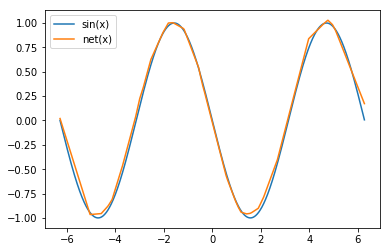

In [7]:
test_x = torch.arange(-2*math.pi, 2*math.pi, step=0.01).unsqueeze(1)
test_y = torch.sin(test_x + t_b)

test_f, _, _ = net(test_x, t_params)

plt.plot(test_x.data.numpy(), test_y.data.numpy(), label='sin(x)')
plt.plot(test_x.data.numpy(), test_f.data.numpy(), label='net(x)')
plt.legend()
plt.savefig('daml-sine.png')

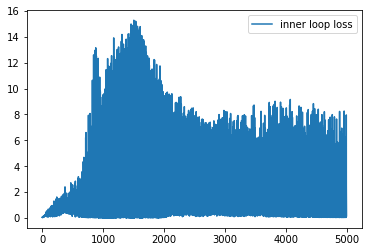

In [9]:
def plot_loss(inner_loop_loss,name="Loss Curve"):
    plt.plot(inner_loop_loss, label=name)
    plt.legend()
plot_loss(outer_lopp_loss)